In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, 
                      activation='relu', input_shape=input_shape))
    
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i)/2)), strides=1, 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [9]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5326, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 170432)            0         
_________________________________________________________________
dropout (Dropout)            (None, 170432)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2726928   
Total params: 2,727,760
Trainable params: 2,727,760
Non-trainable params: 0
___________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1768, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1744, 32)          25632     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 582, 32)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 558, 64)           51264     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2734 - acc: 0.2856
Epoch 00001: val_loss improved from inf to 1.90840, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_checkpoint/001-1.9084.hdf5
36805/36805 [==============================] - 19s 516us/sample - loss: 2.2733 - acc: 0.2856 - val_loss: 1.9084 - val_acc: 0.4027
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7133 - acc: 0.4737
Epoch 00002: val_loss improved from 1.90840 to 1.69665, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_checkpoint/002-1.6967.hdf5
36805/36805 [==============================] - 18s 491us/sample - loss: 1.7133 - acc: 0.4737 - val_loss: 1.6967 - val_acc: 0.4729
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4607 - acc: 0.5562
Epoch 00003: val_loss improved from 1.69665 to 1.60309, s


1D_CNN_1_only_conv_pool_3_ch_32_DO Model


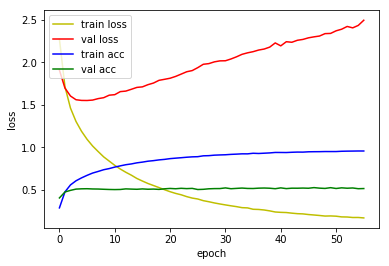

4815/4815 [==============================] - 1s 243us/sample - loss: 1.6095 - acc: 0.4910
Loss: 1.6094556549504044 Accuracy: 0.49096572

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0723 - acc: 0.3291
Epoch 00001: val_loss improved from inf to 1.65380, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_checkpoint/001-1.6538.hdf5
36805/36805 [==============================] - 27s 743us/sample - loss: 2.0722 - acc: 0.3292 - val_loss: 1.6538 - val_acc: 0.4859
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5426 - acc: 0.5187
Epoch 00002: val_loss improved from 1.65380 to 1.42042, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_checkpoint/002-1.4204.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 1.5426 - acc: 0.5187 - val_loss: 1.4204 - val_acc: 0.5716
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9630
Epoch 00056: val_loss did not improve from 1.11818
36805/36805 [==============================] - 27s 727us/sample - loss: 0.1278 - acc: 0.9630 - val_loss: 1.5115 - val_acc: 0.7021
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9636
Epoch 00057: val_loss did not improve from 1.11818
36805/36805 [==============================] - 27s 722us/sample - loss: 0.1244 - acc: 0.9636 - val_loss: 1.5106 - val_acc: 0.6967
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9656
Epoch 00058: val_loss did not improve from 1.11818
36805/36805 [==============================] - 27s 726us/sample - loss: 0.1223 - acc: 0.9656 - val_loss: 1.5122 - val_acc: 0.7037
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9655
Epoch 00059: val_loss did not improve from 1.11818
36805/36805 [=====

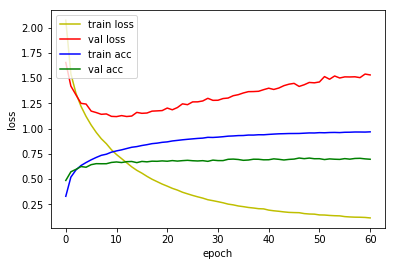

4815/4815 [==============================] - 2s 327us/sample - loss: 1.2243 - acc: 0.6276
Loss: 1.2243124568202415 Accuracy: 0.627622

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1528 - acc: 0.2923
Epoch 00001: val_loss improved from inf to 1.70576, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/001-1.7058.hdf5
36805/36805 [==============================] - 31s 831us/sample - loss: 2.1528 - acc: 0.2923 - val_loss: 1.7058 - val_acc: 0.4414
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6413 - acc: 0.4732
Epoch 00002: val_loss improved from 1.70576 to 1.43715, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/002-1.4372.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 1.6413 - acc: 0.4732 - val_loss: 1.4372 - val_acc: 0.5460
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4861 - acc: 0.8559
Epoch 00023: val_loss improved from 0.72538 to 0.71173, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/023-0.7117.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 0.4861 - acc: 0.8559 - val_loss: 0.7117 - val_acc: 0.7966
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4674 - acc: 0.8633
Epoch 00024: val_loss improved from 0.71173 to 0.68632, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_checkpoint/024-0.6863.hdf5
36805/36805 [==============================] - 30s 820us/sample - loss: 0.4674 - acc: 0.8633 - val_loss: 0.6863 - val_acc: 0.8057
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4454 - acc: 0.8677
Epoch 00025: val_loss did not improve from 0.68632
36805/36805 [==============================] - 30s 818us/sample - loss: 0.4454 - acc: 0.8677 - v

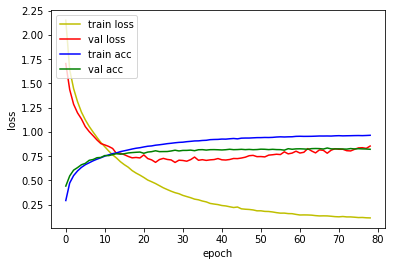

4815/4815 [==============================] - 2s 362us/sample - loss: 0.7812 - acc: 0.7772
Loss: 0.7812266974805672 Accuracy: 0.77715474

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1416 - acc: 0.2922
Epoch 00001: val_loss improved from inf to 1.60438, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/001-1.6044.hdf5
36805/36805 [==============================] - 34s 919us/sample - loss: 2.1415 - acc: 0.2922 - val_loss: 1.6044 - val_acc: 0.4924
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5552 - acc: 0.5040
Epoch 00002: val_loss improved from 1.60438 to 1.29814, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/002-1.2981.hdf5
36805/36805 [==============================] - 33s 896us/sample - loss: 1.5552 - acc: 0.5040 - val_loss: 1.2981 - val_acc: 0.6073
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2890 - acc: 0.9102
Epoch 00024: val_loss did not improve from 0.37261
36805/36805 [==============================] - 33s 896us/sample - loss: 0.2890 - acc: 0.9103 - val_loss: 0.3922 - val_acc: 0.8919
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2826 - acc: 0.9126
Epoch 00025: val_loss improved from 0.37261 to 0.35100, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_checkpoint/025-0.3510.hdf5
36805/36805 [==============================] - 33s 896us/sample - loss: 0.2826 - acc: 0.9126 - val_loss: 0.3510 - val_acc: 0.9038
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2678 - acc: 0.9167
Epoch 00026: val_loss did not improve from 0.35100
36805/36805 [==============================] - 33s 894us/sample - loss: 0.2678 - acc: 0.9167 - val_loss: 0.3871 - val_acc: 0.9005
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9554
Epoch 00053: val_loss did not improve from 0.34398
36805/36805 [==============================] - 33s 889us/sample - loss: 0.1343 - acc: 0.9554 - val_loss: 0.3732 - val_acc: 0.9136
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9600
Epoch 00054: val_loss did not improve from 0.34398
36805/36805 [==============================] - 33s 889us/sample - loss: 0.1251 - acc: 0.9600 - val_loss: 0.3577 - val_acc: 0.9189
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1244 - acc: 0.9599
Epoch 00055: val_loss did not improve from 0.34398
36805/36805 [==============================] - 33s 889us/sample - loss: 0.1246 - acc: 0.9598 - val_loss: 0.3849 - val_acc: 0.9159
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1296 - acc: 0.9577
Epoch 00056: val_loss did not improve from 0.34398
36805/36805 [=====

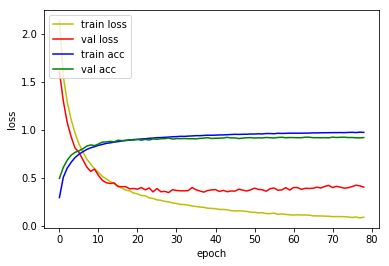

4815/4815 [==============================] - 2s 402us/sample - loss: 0.4359 - acc: 0.8731
Loss: 0.4358552090351703 Accuracy: 0.8731049

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1571 - acc: 0.2905
Epoch 00001: val_loss improved from inf to 1.52204, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/001-1.5220.hdf5
36805/36805 [==============================] - 35s 954us/sample - loss: 2.1571 - acc: 0.2904 - val_loss: 1.5220 - val_acc: 0.5420
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4703 - acc: 0.5268
Epoch 00002: val_loss improved from 1.52204 to 1.13702, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/002-1.1370.hdf5
36805/36805 [==============================] - 34s 925us/sample - loss: 1.4703 - acc: 0.5268 - val_loss: 1.1370 - val_acc: 0.6569
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2125 - acc: 0.9306
Epoch 00024: val_loss did not improve from 0.21093
36805/36805 [==============================] - 34s 927us/sample - loss: 0.2125 - acc: 0.9306 - val_loss: 0.2132 - val_acc: 0.9406
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9321
Epoch 00025: val_loss improved from 0.21093 to 0.20507, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_checkpoint/025-0.2051.hdf5
36805/36805 [==============================] - 34s 929us/sample - loss: 0.2075 - acc: 0.9321 - val_loss: 0.2051 - val_acc: 0.9432
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1977 - acc: 0.9354
Epoch 00026: val_loss did not improve from 0.20507
36805/36805 [==============================] - 34s 927us/sample - loss: 0.1977 - acc: 0.9354 - val_loss: 0.2229 - val_acc: 0.9299
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1016 - acc: 0.9643
Epoch 00051: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 928us/sample - loss: 0.1016 - acc: 0.9643 - val_loss: 0.1963 - val_acc: 0.9513
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9671
Epoch 00052: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 927us/sample - loss: 0.0977 - acc: 0.9671 - val_loss: 0.1904 - val_acc: 0.9511
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9662
Epoch 00053: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 928us/sample - loss: 0.0962 - acc: 0.9662 - val_loss: 0.1847 - val_acc: 0.9534
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9670
Epoch 00054: val_loss did not improve from 0.18157
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9774
Epoch 00081: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 925us/sample - loss: 0.0659 - acc: 0.9774 - val_loss: 0.2190 - val_acc: 0.9520
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9799
Epoch 00082: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 926us/sample - loss: 0.0584 - acc: 0.9799 - val_loss: 0.2230 - val_acc: 0.9541
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9783
Epoch 00083: val_loss did not improve from 0.18157
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0632 - acc: 0.9783 - val_loss: 0.2319 - val_acc: 0.9509
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9793
Epoch 00084: val_loss did not improve from 0.18157
36805/36805 [=====

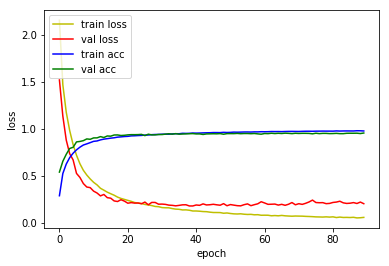

4815/4815 [==============================] - 2s 441us/sample - loss: 0.2233 - acc: 0.9358
Loss: 0.22331035707846114 Accuracy: 0.9358255

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1852 - acc: 0.2767
Epoch 00001: val_loss improved from inf to 1.53534, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_checkpoint/001-1.5353.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 2.1851 - acc: 0.2768 - val_loss: 1.5353 - val_acc: 0.5113
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3668 - acc: 0.5530
Epoch 00002: val_loss improved from 1.53534 to 0.94214, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_checkpoint/002-0.9421.hdf5
36805/36805 [==============================] - 35s 963us/sample - loss: 1.3667 - acc: 0.5530 - val_loss: 0.9421 - val_acc: 0.7130
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1706 - acc: 0.9441
Epoch 00024: val_loss improved from 0.17999 to 0.16746, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_checkpoint/024-0.1675.hdf5
36805/36805 [==============================] - 34s 923us/sample - loss: 0.1705 - acc: 0.9441 - val_loss: 0.1675 - val_acc: 0.9504
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1583 - acc: 0.9481
Epoch 00025: val_loss did not improve from 0.16746
36805/36805 [==============================] - 34s 923us/sample - loss: 0.1583 - acc: 0.9481 - val_loss: 0.1763 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1524 - acc: 0.9499
Epoch 00026: val_loss did not improve from 0.16746
36805/36805 [==============================] - 34s 928us/sample - loss: 0.1525 - acc: 0.9499 - val_loss: 0.1717 - val_acc: 0.9497
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9752
Epoch 00053: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 922us/sample - loss: 0.0721 - acc: 0.9752 - val_loss: 0.1933 - val_acc: 0.9553
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9762
Epoch 00054: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0698 - acc: 0.9762 - val_loss: 0.1810 - val_acc: 0.9539
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0723 - acc: 0.9764
Epoch 00055: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0723 - acc: 0.9764 - val_loss: 0.1730 - val_acc: 0.9574
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9765
Epoch 00056: val_loss did not improve from 0.15296
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9847
Epoch 00083: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 919us/sample - loss: 0.0460 - acc: 0.9847 - val_loss: 0.1984 - val_acc: 0.9581
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9856
Epoch 00084: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 919us/sample - loss: 0.0423 - acc: 0.9856 - val_loss: 0.1928 - val_acc: 0.9588
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9864
Epoch 00085: val_loss did not improve from 0.15296
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0426 - acc: 0.9864 - val_loss: 0.1947 - val_acc: 0.9618
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9849
Epoch 00086: val_loss did not improve from 0.15296
36805/36805 [=====

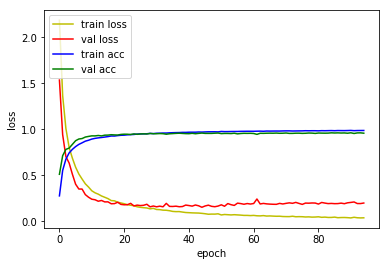

4815/4815 [==============================] - 2s 430us/sample - loss: 0.2374 - acc: 0.9375
Loss: 0.23735378314339606 Accuracy: 0.937487



In [10]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_DO'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 170432)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 170432)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2726928   
Total params: 2,727,760
Trainable params: 2,727,760
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 277us/sample - loss: 1.6095 - acc: 0.4910


4815/4815 [==============================] - 2s 434us/sample - loss: 0.2233 - acc: 0.9358
Loss: 0.22331035707846114 Accuracy: 0.9358255

1D_CNN_6_only_conv_pool_3_ch_32_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1768, 32)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1744, 32)          25632     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (

In [12]:
def build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [13]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 5302, 32)          128       
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 1768, 32)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 1744, 64)          51264     
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1413 - acc: 0.3751
Epoch 00001: val_loss improved from inf to 1.77901, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_BN_checkpoint/001-1.7790.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 2.1414 - acc: 0.3751 - val_loss: 1.7790 - val_acc: 0.4661
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1800 - acc: 0.6332
Epoch 00002: val_loss improved from 1.77901 to 1.70061, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_BN_checkpoint/002-1.7006.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 1.1800 - acc: 0.6332 - val_loss: 1.7006 - val_acc: 0.4969
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8344 - acc: 0.7430
Epoch 00003: val_loss did not improve from 1.70061
36805/36805 [==============================] - 27s 731

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0687 - acc: 0.9862
Epoch 00030: val_loss did not improve from 1.70061
36805/36805 [==============================] - 26s 719us/sample - loss: 0.0687 - acc: 0.9863 - val_loss: 4.1212 - val_acc: 0.4757
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9907
Epoch 00031: val_loss did not improve from 1.70061
36805/36805 [==============================] - 27s 722us/sample - loss: 0.0516 - acc: 0.9907 - val_loss: 4.0333 - val_acc: 0.4917
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9893
Epoch 00032: val_loss did not improve from 1.70061
36805/36805 [==============================] - 27s 720us/sample - loss: 0.0571 - acc: 0.9893 - val_loss: 4.1279 - val_acc: 0.4833
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9868
Epoch 00033: val_loss did not improve from 1.70061
36805/36805 [=====

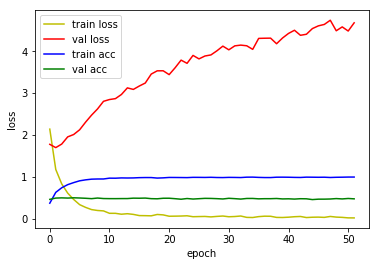

4815/4815 [==============================] - 2s 386us/sample - loss: 1.7975 - acc: 0.4629
Loss: 1.797541138712367 Accuracy: 0.46292835

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2171 - acc: 0.4126
Epoch 00001: val_loss improved from inf to 2.68389, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_BN_checkpoint/001-2.6839.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 2.2170 - acc: 0.4126 - val_loss: 2.6839 - val_acc: 0.3170
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1924 - acc: 0.6522
Epoch 00002: val_loss improved from 2.68389 to 1.65701, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_BN_checkpoint/002-1.6570.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 1.1925 - acc: 0.6522 - val_loss: 1.6570 - val_acc: 0.5539
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

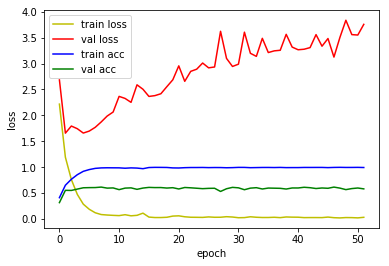

4815/4815 [==============================] - 3s 520us/sample - loss: 1.7067 - acc: 0.5265
Loss: 1.7066909554096275 Accuracy: 0.5264797

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8393 - acc: 0.4732
Epoch 00001: val_loss improved from inf to 4.48454, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_BN_checkpoint/001-4.4845.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.8391 - acc: 0.4732 - val_loss: 4.4845 - val_acc: 0.2441
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0994 - acc: 0.6792
Epoch 00002: val_loss improved from 4.48454 to 1.21671, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_BN_checkpoint/002-1.2167.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.0994 - acc: 0.6791 - val_loss: 1.2167 - val_acc: 0.6678
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9940
Epoch 00029: val_loss did not improve from 1.04461
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0279 - acc: 0.9940 - val_loss: 1.6215 - val_acc: 0.7487
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9942
Epoch 00030: val_loss did not improve from 1.04461
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0282 - acc: 0.9942 - val_loss: 1.5059 - val_acc: 0.7591
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9909
Epoch 00031: val_loss did not improve from 1.04461
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0373 - acc: 0.9909 - val_loss: 1.6981 - val_acc: 0.7335
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9953
Epoch 00032: val_loss did not improve from 1.04461
36805/36805 [===========

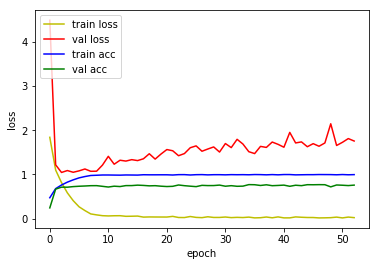

4815/4815 [==============================] - 3s 601us/sample - loss: 1.1312 - acc: 0.6856
Loss: 1.1312228388504075 Accuracy: 0.68556595

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6385 - acc: 0.4965
Epoch 00001: val_loss improved from inf to 10.06618, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_BN_checkpoint/001-10.0662.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.6384 - acc: 0.4966 - val_loss: 10.0662 - val_acc: 0.1058
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9465 - acc: 0.7163
Epoch 00002: val_loss improved from 10.06618 to 0.95020, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_BN_checkpoint/002-0.9502.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.9464 - acc: 0.7163 - val_loss: 0.9502 - val_acc: 0.7221
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9927
Epoch 00028: val_loss did not improve from 0.49497
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0269 - acc: 0.9926 - val_loss: 0.6608 - val_acc: 0.8598
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9923
Epoch 00029: val_loss did not improve from 0.49497
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0290 - acc: 0.9923 - val_loss: 0.8369 - val_acc: 0.8365
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9968
Epoch 00030: val_loss did not improve from 0.49497
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0133 - acc: 0.9968 - val_loss: 0.7658 - val_acc: 0.8544
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9950
Epoch 00031: val_loss did not improve from 0.49497
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9992
Epoch 00058: val_loss did not improve from 0.49497
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0041 - acc: 0.9992 - val_loss: 0.6372 - val_acc: 0.8917

1D_CNN_4_only_conv_pool_3_ch_32_BN Model


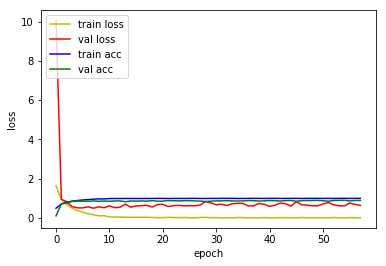

4815/4815 [==============================] - 3s 658us/sample - loss: 0.5865 - acc: 0.8355
Loss: 0.5865089924659809 Accuracy: 0.835514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4487 - acc: 0.5533
Epoch 00001: val_loss improved from inf to 2.22242, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/001-2.2224.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.4486 - acc: 0.5533 - val_loss: 2.2224 - val_acc: 0.3946
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6899 - acc: 0.7938
Epoch 00002: val_loss improved from 2.22242 to 0.66348, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_BN_checkpoint/002-0.6635.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.6899 - acc: 0.7938 - val_loss: 0.6635 - val_acc: 0.8083
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9992
Epoch 00057: val_loss did not improve from 0.27293
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0037 - acc: 0.9992 - val_loss: 0.3068 - val_acc: 0.9399
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9992
Epoch 00058: val_loss did not improve from 0.27293
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0033 - acc: 0.9992 - val_loss: 0.3182 - val_acc: 0.9394
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9963
Epoch 00059: val_loss did not improve from 0.27293
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0120 - acc: 0.9963 - val_loss: 0.4735 - val_acc: 0.9096
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9967
Epoch 00060: val_loss did not improve from 0.27293
36805/36805 [===========

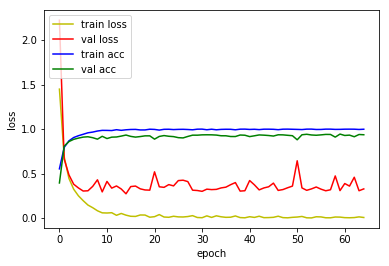

4815/4815 [==============================] - 3s 701us/sample - loss: 0.3645 - acc: 0.9070
Loss: 0.3644524740095822 Accuracy: 0.90695745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3669 - acc: 0.5779
Epoch 00001: val_loss improved from inf to 3.76779, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_BN_checkpoint/001-3.7678.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.3668 - acc: 0.5779 - val_loss: 3.7678 - val_acc: 0.2297
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5848 - acc: 0.8225
Epoch 00002: val_loss improved from 3.76779 to 0.48234, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_BN_checkpoint/002-0.4823.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.5848 - acc: 0.8225 - val_loss: 0.4823 - val_acc: 0.8537
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9939
Epoch 00028: val_loss did not improve from 0.21242
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0224 - acc: 0.9939 - val_loss: 0.2213 - val_acc: 0.9429
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9966
Epoch 00029: val_loss did not improve from 0.21242
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0141 - acc: 0.9966 - val_loss: 0.3078 - val_acc: 0.9231
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9918
Epoch 00030: val_loss improved from 0.21242 to 0.20155, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_BN_checkpoint/030-0.2015.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0284 - acc: 0.9918 - val_loss: 0.2015 - val_acc: 0.9450
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9984
Epoch 00057: val_loss did not improve from 0.20046
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0061 - acc: 0.9984 - val_loss: 0.2455 - val_acc: 0.9467
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.20046
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0070 - acc: 0.9983 - val_loss: 0.2546 - val_acc: 0.9385
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9967
Epoch 00059: val_loss did not improve from 0.20046
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0111 - acc: 0.9967 - val_loss: 0.2870 - val_acc: 0.9355
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9958
Epoch 00060: val_loss did not improve from 0.20046
36805/36805 [===========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9990
Epoch 00115: val_loss did not improve from 0.19712
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0032 - acc: 0.9990 - val_loss: 0.2623 - val_acc: 0.9474
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9983
Epoch 00116: val_loss did not improve from 0.19712
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0053 - acc: 0.9983 - val_loss: 0.2474 - val_acc: 0.9502
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9988
Epoch 00117: val_loss did not improve from 0.19712
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0042 - acc: 0.9988 - val_loss: 0.2544 - val_acc: 0.9497
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9970
Epoch 00118: val_loss did not improve from 0.19712
36805/36805 [=======

Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9992
Epoch 00145: val_loss did not improve from 0.19712
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0029 - acc: 0.9992 - val_loss: 0.2268 - val_acc: 0.9555

1D_CNN_6_only_conv_pool_3_ch_32_BN Model


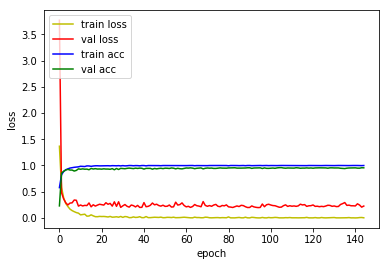

4815/4815 [==============================] - 4s 752us/sample - loss: 0.2536 - acc: 0.9475
Loss: 0.2536296891936353 Accuracy: 0.9474559



In [14]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_21 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
_________________________________________________________________
4815/4815 [==============================] - 2s 493us/sample - loss: 1.7975 - acc: 0.4629

4815/4815 [==============================] - 4s 782us/sample - loss: 0.3645 - acc: 0.9070
Loss: 0.3644524740095822 Accuracy: 0.90695745

1D_CNN_6_only_conv_pool_3_ch_32_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 5302, 32)          128       
_________________________________________________________________
max_pooling1d_79 (MaxPooling (

In [16]:
def build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=32, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=32*(2**int((i+1)/2)), strides=1))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    return model

In [17]:
for i in range(1, 7):
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 170432)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
_________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_57 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 5326, 32)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_58 (B (None, 5302, 32)          128       
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 1768, 32)          0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 1744, 64)          51264     
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2920 - acc: 0.3385
Epoch 00001: val_loss improved from inf to 1.84707, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-1.8471.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.2919 - acc: 0.3385 - val_loss: 1.8471 - val_acc: 0.4451
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3616 - acc: 0.5732
Epoch 00002: val_loss improved from 1.84707 to 1.71161, saving model to model/checkpoint/1D_CNN_1_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.7116.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 1.3616 - acc: 0.5732 - val_loss: 1.7116 - val_acc: 0.4936
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0553 - acc: 0.6658
Epoch 00003: val_loss improved from 1.71161 to 1.69418, saving model to model/checkpoint/1D_CNN_1_onl

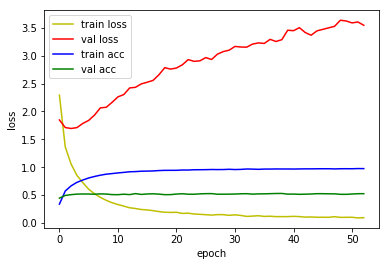

4815/4815 [==============================] - 3s 583us/sample - loss: 1.7332 - acc: 0.4833
Loss: 1.733176219277664 Accuracy: 0.4832814

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9358 - acc: 0.3300
Epoch 00001: val_loss improved from inf to 2.85286, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-2.8529.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.9360 - acc: 0.3300 - val_loss: 2.8529 - val_acc: 0.2986
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8536 - acc: 0.5334
Epoch 00002: val_loss improved from 2.85286 to 1.72303, saving model to model/checkpoint/1D_CNN_2_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.7230.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8537 - acc: 0.5334 - val_loss: 1.7230 - val_acc: 0.5590
Epoch 3/500
36800/36805 [============================>.] - ETA: 


1D_CNN_2_only_conv_pool_3_ch_32_DO_BN Model


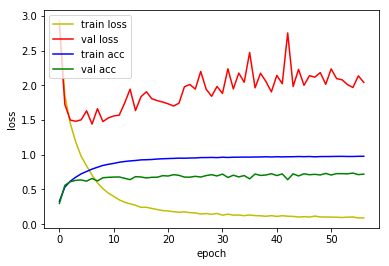

4815/4815 [==============================] - 3s 705us/sample - loss: 1.5087 - acc: 0.6314
Loss: 1.5087162107941023 Accuracy: 0.63136035

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6270 - acc: 0.3812
Epoch 00001: val_loss improved from inf to 6.11845, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-6.1184.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.6271 - acc: 0.3812 - val_loss: 6.1184 - val_acc: 0.1537
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6258 - acc: 0.5779
Epoch 00002: val_loss improved from 6.11845 to 1.13443, saving model to model/checkpoint/1D_CNN_3_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.1344.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.6256 - acc: 0.5779 - val_loss: 1.1344 - val_acc: 0.6949
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9649
Epoch 00028: val_loss did not improve from 0.79160
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1200 - acc: 0.9649 - val_loss: 0.9805 - val_acc: 0.8304
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9693
Epoch 00029: val_loss did not improve from 0.79160
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1052 - acc: 0.9693 - val_loss: 1.0152 - val_acc: 0.8197
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0972 - acc: 0.9708
Epoch 00030: val_loss did not improve from 0.79160
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0973 - acc: 0.9708 - val_loss: 0.9574 - val_acc: 0.8330
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1055 - acc: 0.9699
Epoch 00031: val_loss did not improve from 0.79160
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9831
Epoch 00058: val_loss did not improve from 0.79160
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0682 - acc: 0.9831 - val_loss: 1.1026 - val_acc: 0.8355

1D_CNN_3_only_conv_pool_3_ch_32_DO_BN Model


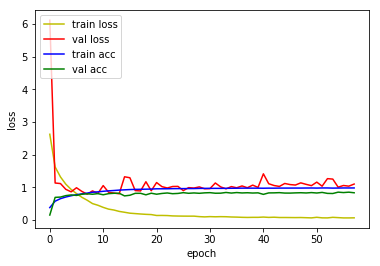

4815/4815 [==============================] - 4s 801us/sample - loss: 0.9034 - acc: 0.7657
Loss: 0.9033839555172906 Accuracy: 0.7657321

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4298 - acc: 0.3574
Epoch 00001: val_loss improved from inf to 8.00436, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-8.0044.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 2.4299 - acc: 0.3573 - val_loss: 8.0044 - val_acc: 0.1463
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4786 - acc: 0.5759
Epoch 00002: val_loss improved from 8.00436 to 0.97784, saving model to model/checkpoint/1D_CNN_4_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-0.9778.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.4788 - acc: 0.5759 - val_loss: 0.9778 - val_acc: 0.7112
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9673
Epoch 00027: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0993 - acc: 0.9673 - val_loss: 0.3697 - val_acc: 0.9199
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9704
Epoch 00028: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0899 - acc: 0.9704 - val_loss: 0.3724 - val_acc: 0.9117
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0903 - acc: 0.9704
Epoch 00029: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0903 - acc: 0.9704 - val_loss: 0.4061 - val_acc: 0.9075
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9707
Epoch 00030: val_loss did not improve from 0.35209
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9873
Epoch 00057: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0403 - acc: 0.9873 - val_loss: 0.5471 - val_acc: 0.9052
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9855
Epoch 00058: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0459 - acc: 0.9855 - val_loss: 0.4509 - val_acc: 0.9164
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9870
Epoch 00059: val_loss did not improve from 0.35209
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0427 - acc: 0.9869 - val_loss: 0.4669 - val_acc: 0.9187
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9862
Epoch 00060: val_loss did not improve from 0.35209
36805/36805 [===========

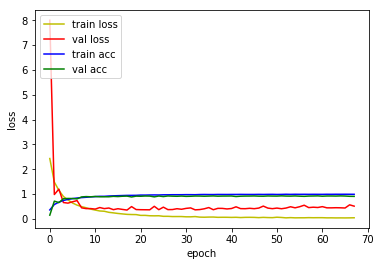

4815/4815 [==============================] - 4s 858us/sample - loss: 0.4129 - acc: 0.8879
Loss: 0.4129287703881506 Accuracy: 0.88785046

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2990 - acc: 0.3801
Epoch 00001: val_loss improved from inf to 6.66314, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-6.6631.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 2.2989 - acc: 0.3801 - val_loss: 6.6631 - val_acc: 0.1491
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2134 - acc: 0.6423
Epoch 00002: val_loss improved from 6.66314 to 1.01406, saving model to model/checkpoint/1D_CNN_5_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-1.0141.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.2137 - acc: 0.6422 - val_loss: 1.0141 - val_acc: 0.7077
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9841
Epoch 00027: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0500 - acc: 0.9841 - val_loss: 0.2497 - val_acc: 0.9425
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9839
Epoch 00028: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0489 - acc: 0.9839 - val_loss: 0.2930 - val_acc: 0.9341
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9840
Epoch 00029: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0491 - acc: 0.9840 - val_loss: 0.2728 - val_acc: 0.9415
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9817
Epoch 00030: val_loss did not improve from 0.21381
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9934
Epoch 00057: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0215 - acc: 0.9934 - val_loss: 0.2530 - val_acc: 0.9511
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9903
Epoch 00058: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0301 - acc: 0.9903 - val_loss: 0.2474 - val_acc: 0.9529
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.21381
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0172 - acc: 0.9945 - val_loss: 0.2141 - val_acc: 0.9609
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9909
Epoch 00060: val_loss did not improve from 0.21381
36805/36805 [===========

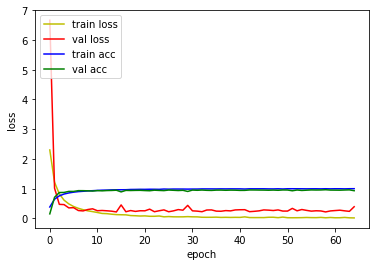

4815/4815 [==============================] - 4s 913us/sample - loss: 0.2675 - acc: 0.9242
Loss: 0.2674995232686818 Accuracy: 0.92419523

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1653 - acc: 0.4034
Epoch 00001: val_loss improved from inf to 4.76863, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_BN_checkpoint/001-4.7686.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.1654 - acc: 0.4034 - val_loss: 4.7686 - val_acc: 0.2003
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0654 - acc: 0.6701
Epoch 00002: val_loss improved from 4.76863 to 0.67890, saving model to model/checkpoint/1D_CNN_6_only_conv_pool_3_ch_32_DO_BN_checkpoint/002-0.6789.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.0658 - acc: 0.6700 - val_loss: 0.6789 - val_acc: 0.7866
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9899
Epoch 00055: val_loss did not improve from 0.16928
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0323 - acc: 0.9899 - val_loss: 0.1893 - val_acc: 0.9567
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9957
Epoch 00056: val_loss did not improve from 0.16928
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0144 - acc: 0.9957 - val_loss: 0.1957 - val_acc: 0.9588
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9942
Epoch 00057: val_loss did not improve from 0.16928
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0179 - acc: 0.9942 - val_loss: 0.2179 - val_acc: 0.9536
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9897
Epoch 00058: val_loss did not improve from 0.16928
36805/36805 [===========

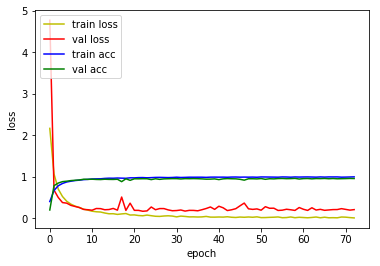

4815/4815 [==============================] - 5s 964us/sample - loss: 0.2220 - acc: 0.9379
Loss: 0.22201685277070088 Accuracy: 0.9379024



In [18]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_DO_BN'.format(i)
    model = build_1d_cnn_only_conv_pool_3_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
for i in range(1, 7):
    model_name = '1D_CNN_{}_only_conv_pool_3_ch_32_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_only_conv_pool_3_ch_32_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_63 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 5326, 32)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 170432)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 170432)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                2726928   
Total params: 2,727,888
Trainable params: 2,727,824
Non-trainable params: 64
____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2675 - acc: 0.9242
Loss: 0.2674995232686818 Accuracy: 0.92419523

1D_CNN_6_only_conv_pool_3_ch_32_DO_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 15976, 32)         832       
_________________________________________________________________
batch_normalization_v1_78 (B (None, 15976, 32)         128       
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 5326, 32)          0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 5302, 32)          25632     
_________________________________________________________________
batch_normalization_v1_79 (B (None, 5302, 32)          128       
_________________________________________________________________
max_pooling1d_121 (MaxPoolin 